In [119]:
# IMPORTS
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import pickle
import pandas_datareader as webreader
import datetime as dt
from math import sqrt
import datetime


import tensorflow.keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import date, timedelta, datetime
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15963723192395618924,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1401808078
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5218950203599089598
 physical_device_desc: "device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [120]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'tanh'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'tanh',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'tanh'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'mean_squared_error')
    print(model.summary())
  
    # Training the data
    early_stop = EarlyStopping(monitor='loss', patience=500, verbose=1)
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=early_stop)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [121]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []
    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean((np.abs(np.subtract(Y_test, Y_hat)/ Y_test))) * 100
    # Median Absolute Percentage Error (MDAPE)
    mdape = np.median((np.abs(np.subtract(Y_test, Y_hat)/ Y_test)) ) * 100
    return mse, rmse, r, Y_test, Y_hat, mape, mdape

In [122]:
# COMMON
symbol = 'AAPL'
stockname = 'AAPL'
timeWindowInYears = 5
timeWindowInDays = timeWindowInYears * 365
testDays = 100
FEATURES = ['Close','High','Low', 'Open', 'Adj Close']
# FEATURES = ['Close']

In [123]:
# PULL DATASET FROM YAHOO FINANCIALS
today = datetime(2022, 2, 27)
date_today = today.strftime("%Y-%m-%d")
date_start = pd.Timestamp('2022-02-27') - timedelta(days=timeWindowInDays)
print(date_today)
df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
df.head()

2022-02-27


High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2017-02-28  34.360001  34.174999  34.270000  34.247501   93931600.0  32.335125
2017-03-01  35.037498  34.400002  34.472500  34.947498  145658400.0  32.996025
2017-03-02  35.070000  34.689999  35.000000  34.740002  104844000.0  32.800110
2017-03-03  34.957500  34.647499  34.695000  34.945000   84432400.0  32.993668
2017-03-06  34.942501  34.650002  34.842499  34.834999   87000000.0  32.889812

In [124]:
# calculate correlation
df.corr()['Close']

High         0.999748
Low          0.999739
Open         0.999495
Close        1.000000
Volume      -0.167750
Adj Close    0.999977
Name: Close, dtype: float64

In [125]:
# select relevant features
# Extracting the series
dfWithRelevantFeatures = df[FEATURES] # Picking the series with high correlation
print(dfWithRelevantFeatures.tail())

                 Close        High         Low        Open   Adj Close
Date                                                                  
2022-02-18  167.300003  170.539993  166.190002  169.820007  167.300003
2022-02-22  164.320007  166.690002  162.149994  164.979996  164.320007
2022-02-23  160.070007  166.149994  159.750000  165.539993  160.070007
2022-02-24  162.740005  162.850006  152.000000  152.580002  162.740005
2022-02-25  164.850006  165.119995  160.869995  163.839996  164.850006


IndexError: index 5 is out of bounds for axis 0 with size 5

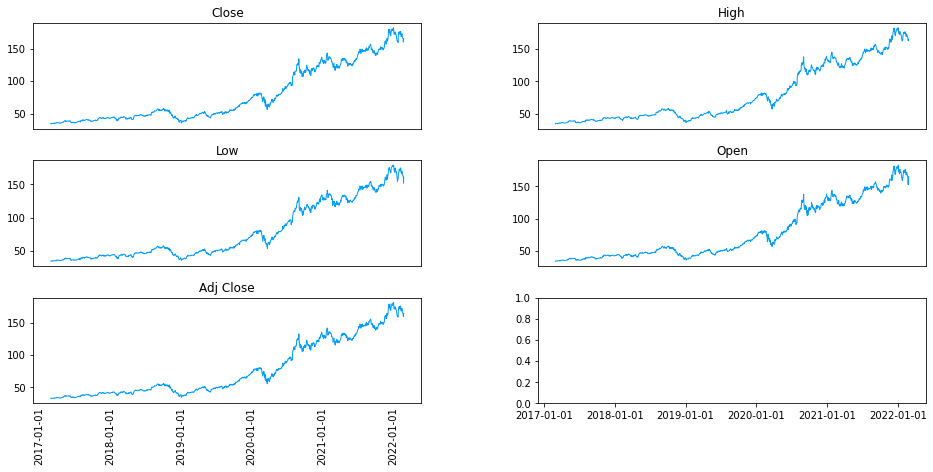

In [126]:
# Plot each column
register_matplotlib_converters()
nrows = 3
ncols = int(round(dfWithRelevantFeatures.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
x = dfWithRelevantFeatures.index
columns = dfWithRelevantFeatures.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
        assetname = columns[f]
        y = dfWithRelevantFeatures[assetname]
        f += 1
        ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i, j].set_title(assetname)
        ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)  

In [127]:
train_data, remaining_data = np.split(dfWithRelevantFeatures, [int(.8 *len(dfWithRelevantFeatures))])
val_data, test_data = np.split(remaining_data, [int(.5 *len(remaining_data))])
print(train_data.shape,val_data.shape,test_data.shape)

(1007, 5) (126, 5) (126, 5)


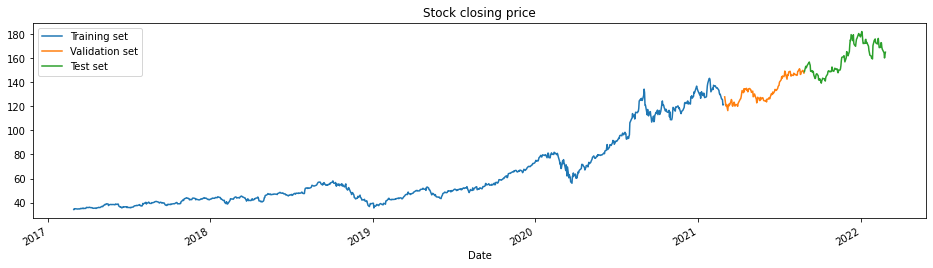

In [128]:
train_data["Close"].plot(figsize=(16,4),legend=True)
val_data["Close"].plot(figsize=(16,4),legend=True)
test_data["Close"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set', 'Validation set', 'Test set'])
plt.title('Stock closing price')
plt.show()


In [129]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.fit_transform(val_data)
test = sc.fit_transform(test_data)
print(train.shape,val.shape,test.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(dfWithRelevantFeatures['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1007, 5) (126, 5) (126, 5)


In [130]:
# MODEL TRAINING PARAMS
timesteps = 30 # 60 is default
hl = [40,35] #[40,35] is default
lr = 0.001 # 0.001 is default
batch_size = 32 # 32 is default
num_epochs = 500 # 500 is default

In [131]:
"""
# HYPERPARAMETER OPTIMISATION
batch_sizes = [32, 64]
timesteps_list = [30, 90]
lrs = [0.0005, 0.001]
for batch in batch_sizes:
    for timestep in timesteps_list:
        for lrt in lrs:
            model,train_error,val_error = fit_model(train,val,timestep,hl,lrt,batch,num_epochs)
            mse, rmse, r2_value,true,predictions,mape,mdape = evaluate_model(model,test,timestep)
            print("MODEL WITH BATCH SIZE OF ", batch, " AND TIMESTEP OF ", timestep, "AND LR OF ", lrt)
            print('MSE = {}'.format(mse))
            print('RMSE = {}'.format(rmse))
            print('R-Squared Score = {}'.format(r2_value))
            print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(mape, 2)) + ' %')
            print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(mdape, 2)) + ' %')
"""

'\n# HYPERPARAMETER OPTIMISATION\nbatch_sizes = [32, 64]\ntimesteps_list = [30, 90]\nlrs = [0.0005, 0.001]\nfor batch in batch_sizes:\n    for timestep in timesteps_list:\n        for lrt in lrs:\n            model,train_error,val_error = fit_model(train,val,timestep,hl,lrt,batch,num_epochs)\n            mse, rmse, r2_value,true,predictions,mape,mdape = evaluate_model(model,test,timestep)\n            print("MODEL WITH BATCH SIZE OF ", batch, " AND TIMESTEP OF ", timestep, "AND LR OF ", lrt)\n            print(\'MSE = {}\'.format(mse))\n            print(\'RMSE = {}\'.format(rmse))\n            print(\'R-Squared Score = {}\'.format(r2_value))\n            print(\'Mean Absolute Percentage Error (MAPE): \' + str(np.round(mape, 2)) + \' %\')\n            print(\'Median Absolute Percentage Error (MDAPE): \' + str(np.round(mdape, 2)) + \' %\')\n'

In [132]:
# train the model
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 30, 5)             180       
_________________________________________________________________
gru_13 (GRU)                 (None, 30, 40)            5640      
_________________________________________________________________
gru_14 (GRU)                 (None, 35)                8085      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 36        
Total params: 13,941
Trainable params: 13,941
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
31/31 [==============================] - 5s 39ms/step - loss: 0.0027 - val_loss: 0.0101
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 0.0062 - val_loss: 0.0176
Epoch 3/500
31/31 [========================

31/31 [==============================] - 0s 11ms/step - loss: 4.9770e-04 - val_loss: 0.0077
Epoch 72/500
31/31 [==============================] - 0s 11ms/step - loss: 5.1056e-04 - val_loss: 0.0078
Epoch 73/500
31/31 [==============================] - 0s 12ms/step - loss: 5.0849e-04 - val_loss: 0.0077
Epoch 74/500
31/31 [==============================] - 0s 11ms/step - loss: 4.9408e-04 - val_loss: 0.0072
Epoch 75/500
31/31 [==============================] - 0s 12ms/step - loss: 4.8027e-04 - val_loss: 0.0065
Epoch 76/500
31/31 [==============================] - 0s 11ms/step - loss: 4.8797e-04 - val_loss: 0.0056
Epoch 77/500
31/31 [==============================] - 0s 11ms/step - loss: 5.2926e-04 - val_loss: 0.0049
Epoch 78/500
31/31 [==============================] - 0s 12ms/step - loss: 5.8192e-04 - val_loss: 0.0044
Epoch 79/500
31/31 [==============================] - 0s 11ms/step - loss: 5.9353e-04 - val_loss: 0.0043
Epoch 80/500
31/31 [==============================] - 0s 12ms/step -

31/31 [==============================] - 0s 11ms/step - loss: 9.2893e-04 - val_loss: 0.0079
Epoch 149/500
31/31 [==============================] - 0s 11ms/step - loss: 4.6660e-04 - val_loss: 0.0048
Epoch 150/500
31/31 [==============================] - 0s 13ms/step - loss: 3.1690e-04 - val_loss: 0.0029
Epoch 151/500
31/31 [==============================] - 0s 12ms/step - loss: 5.8050e-04 - val_loss: 0.0029
Epoch 152/500
31/31 [==============================] - 0s 11ms/step - loss: 5.1560e-04 - val_loss: 0.0045
Epoch 153/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9550e-04 - val_loss: 0.0074
Epoch 154/500
31/31 [==============================] - 0s 11ms/step - loss: 5.9005e-04 - val_loss: 0.0065
Epoch 155/500
31/31 [==============================] - 0s 11ms/step - loss: 3.1401e-04 - val_loss: 0.0039
Epoch 156/500
31/31 [==============================] - 0s 11ms/step - loss: 3.8864e-04 - val_loss: 0.0029
Epoch 157/500
31/31 [==============================] - 0s 11

31/31 [==============================] - 0s 11ms/step - loss: 2.2986e-04 - val_loss: 0.0035
Epoch 226/500
31/31 [==============================] - 0s 11ms/step - loss: 2.2764e-04 - val_loss: 0.0040
Epoch 227/500
31/31 [==============================] - 0s 11ms/step - loss: 2.1775e-04 - val_loss: 0.0037
Epoch 228/500
31/31 [==============================] - 0s 11ms/step - loss: 2.1663e-04 - val_loss: 0.0038
Epoch 229/500
31/31 [==============================] - 0s 11ms/step - loss: 2.1612e-04 - val_loss: 0.0038
Epoch 230/500
31/31 [==============================] - 0s 11ms/step - loss: 2.1598e-04 - val_loss: 0.0038
Epoch 231/500
31/31 [==============================] - 0s 11ms/step - loss: 2.1592e-04 - val_loss: 0.0038
Epoch 232/500
31/31 [==============================] - 0s 11ms/step - loss: 2.1588e-04 - val_loss: 0.0038
Epoch 233/500
31/31 [==============================] - 0s 11ms/step - loss: 2.1583e-04 - val_loss: 0.0038
Epoch 234/500
31/31 [==============================] - 0s 11

31/31 [==============================] - 0s 11ms/step - loss: 9.4127e-04 - val_loss: 0.0028
Epoch 303/500
31/31 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 304/500
31/31 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 305/500
31/31 [==============================] - 0s 12ms/step - loss: 4.4467e-04 - val_loss: 0.0074
Epoch 306/500
31/31 [==============================] - 0s 12ms/step - loss: 4.9906e-04 - val_loss: 0.0030
Epoch 307/500
31/31 [==============================] - 0s 11ms/step - loss: 5.8282e-04 - val_loss: 0.0030
Epoch 308/500
31/31 [==============================] - 0s 12ms/step - loss: 4.3309e-04 - val_loss: 0.0033
Epoch 309/500
31/31 [==============================] - 0s 12ms/step - loss: 2.7478e-04 - val_loss: 0.0038
Epoch 310/500
31/31 [==============================] - 0s 11ms/step - loss: 2.3129e-04 - val_loss: 0.0041
Epoch 311/500
31/31 [==============================] - 0s 12ms/step 

31/31 [==============================] - 0s 12ms/step - loss: 5.1807e-04 - val_loss: 0.0067
Epoch 380/500
31/31 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0073
Epoch 381/500
31/31 [==============================] - 0s 12ms/step - loss: 3.8103e-04 - val_loss: 0.0034
Epoch 382/500
31/31 [==============================] - 0s 12ms/step - loss: 4.6218e-04 - val_loss: 0.0025
Epoch 383/500
31/31 [==============================] - 0s 12ms/step - loss: 6.3332e-04 - val_loss: 0.0031
Epoch 384/500
31/31 [==============================] - 0s 12ms/step - loss: 3.5131e-04 - val_loss: 0.0055
Epoch 385/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0064e-04 - val_loss: 0.0051
Epoch 386/500
31/31 [==============================] - 0s 12ms/step - loss: 2.9090e-04 - val_loss: 0.0031
Epoch 387/500
31/31 [==============================] - 0s 12ms/step - loss: 4.7316e-04 - val_loss: 0.0026
Epoch 388/500
31/31 [==============================] - 0s 12ms/s

31/31 [==============================] - 1s 18ms/step - loss: 4.0094e-04 - val_loss: 0.0058
Epoch 457/500
31/31 [==============================] - 1s 17ms/step - loss: 4.5027e-04 - val_loss: 0.0052
Epoch 458/500
31/31 [==============================] - 1s 20ms/step - loss: 3.3235e-04 - val_loss: 0.0028
Epoch 459/500
31/31 [==============================] - 1s 19ms/step - loss: 5.5449e-04 - val_loss: 0.0025
Epoch 460/500
31/31 [==============================] - 1s 16ms/step - loss: 5.1595e-04 - val_loss: 0.0035
Epoch 461/500
31/31 [==============================] - 0s 14ms/step - loss: 3.8391e-04 - val_loss: 0.0057
Epoch 462/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1540e-04 - val_loss: 0.0051
Epoch 463/500
31/31 [==============================] - 0s 13ms/step - loss: 3.4729e-04 - val_loss: 0.0028
Epoch 464/500
31/31 [==============================] - 0s 13ms/step - loss: 5.8381e-04 - val_loss: 0.0025
Epoch 465/500
31/31 [==============================] - 0s 13

In [115]:

# OR load the model
model = load_model("GRU_GPU_AAPL_25Y_noTA.h5")


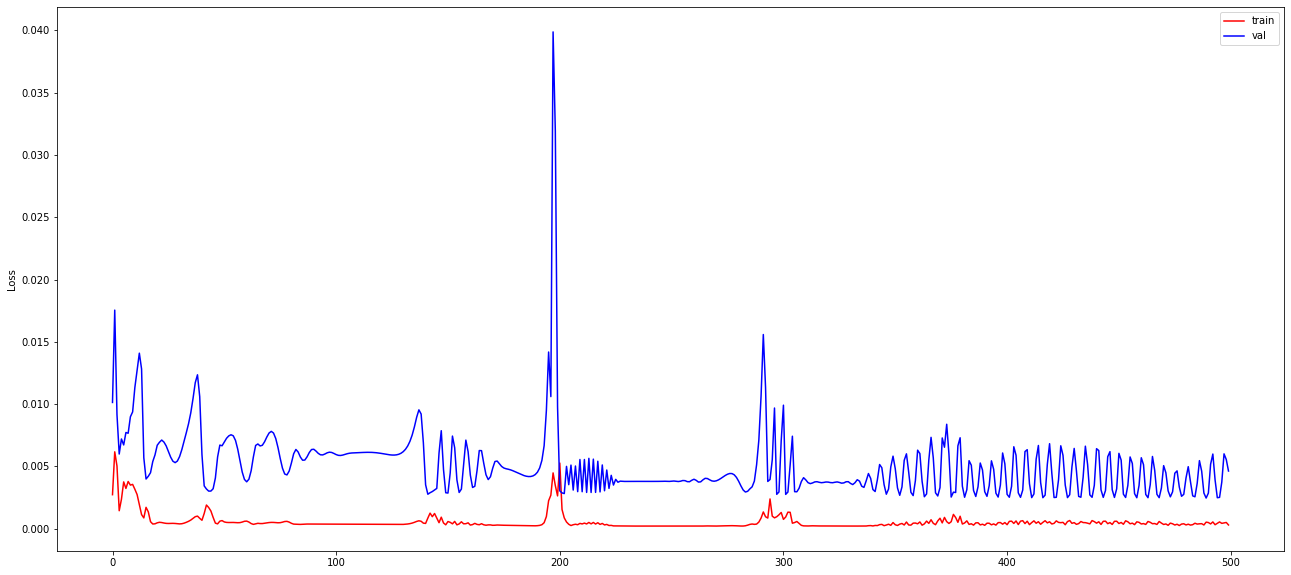

In [133]:
plt.rcParams["figure.figsize"] = (22,10)
plt.plot(train_error,c = 'r')
plt.plot(val_error,c = 'b')
plt.ylabel('Loss')
plt.legend(['train','val'],loc = 'upper right')
plt.show()

In [134]:
mse, rmse, r2_value,true,predictions,mape,mdape = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(mape, 2)) + ' %')
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(mdape, 2)) + ' %')



MSE = 0.005081761097513063
RMSE = 0.0712864720512459
R-Squared Score = 0.9272171646126519
Mean Absolute Percentage Error (MAPE): 96.07 %
Median Absolute Percentage Error (MDAPE): 48.57 %


In [117]:
# FIX DATES (X AXIS) and add differences at the bottom of the graph just like in v2
true_unscaled = scaler_pred.inverse_transform(true.reshape(-1, 1))
predictions_unscaled = (scaler_pred.inverse_transform(predictions))
diff = predictions_unscaled - true_unscaled
percent_diff = (abs(predictions_unscaled - true_unscaled) / true_unscaled) * 100.0
abs_diff = abs(diff)
valid = pd.DataFrame()
valid['Difference'] = diff.flatten()
valid['Abs_Difference'] = abs_diff.flatten()
valid['Percent_Difference'] = percent_diff.flatten()
print(valid)
print("abs diff mean: ", valid['Abs_Difference'].mean())
print("abs diff median: ", valid['Abs_Difference'].median())
print("percent diff mean: ", valid['Percent_Difference'].mean())
print("percent diff median: ", valid['Percent_Difference'].median())
print(valid.describe())

ValueError: Length of values (96) does not match length of index (288)

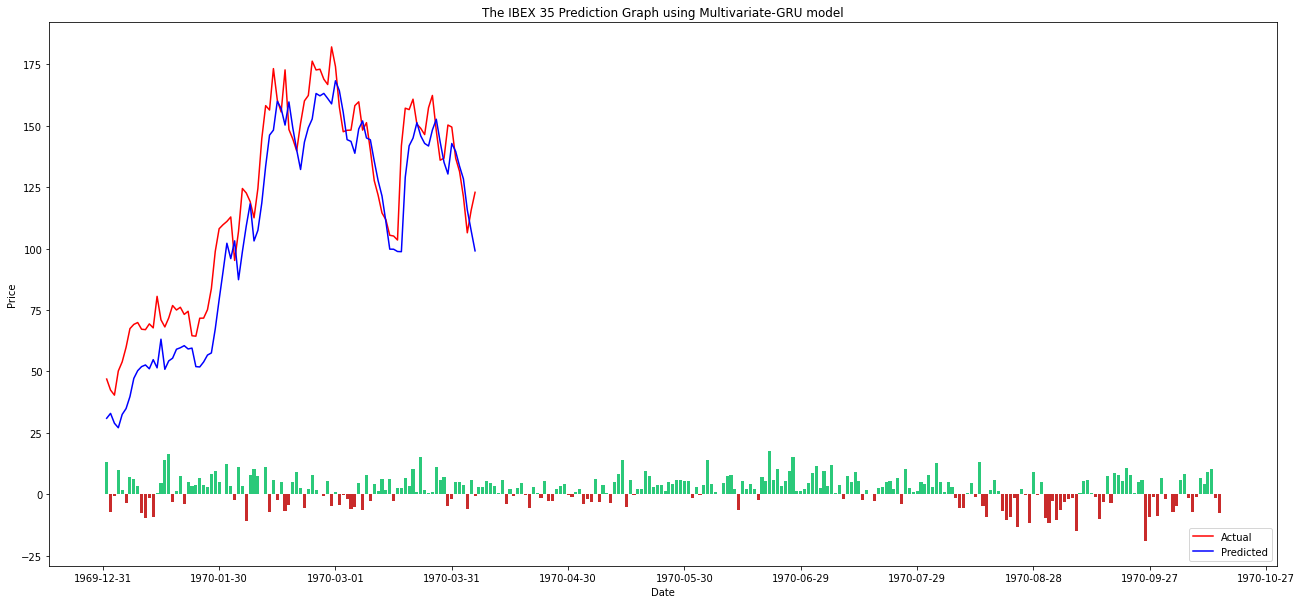

In [118]:
ind = np.arange(len(valid))
                        
plt.rcParams["figure.figsize"] = (22,10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
plt.plot(true_unscaled,c = 'r')
plt.plot(predictions_unscaled,c = 'b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('The IBEX 35 Prediction Graph using Multivariate-GRU model')
plt.legend(['Actual','Predicted'],loc = 'lower right')

y = valid["Difference"]
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"
plt.bar(ind, y, width=0.8, color=valid['diff_color'])

plt.show()

In [172]:
# save the model to disk
model.save("GRU_GPU_IBEX_5Y_noTA.h5")

In [93]:
print(pred)

NameError: name 'pred' is not defined

In [94]:
# BACKTESTING feature
# THIS IS ALL-IN STRATEGY - BUY AND SELL WITH THE MAXIMUM AMOUNT OF MONEY AVAILABLE
CADENCES = [1,3,7]
for CADENCE in CADENCES:
    money = 1000
    correct = 0
    total = 0
    for i in range (0, len(predictions_unscaled), CADENCE):
        #print(i)
        if i > 0:
            total = total + 1
            todays_pred = float(predictions_unscaled[i])
            yesterdays_pred = float(predictions_unscaled[i-CADENCE])
            todays_price = float(true_unscaled[i])
            yesterdays_price = float(true_unscaled[i-CADENCE])
            percent_diff = (abs(todays_price - yesterdays_price) / yesterdays_price) * 100.0
            #print(percent_diff)
            if todays_pred > yesterdays_pred:
                #print("Predicting price rise. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price > yesterdays_price:
                    #print("Prediction was correct! Price was rising", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1

                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")


            else:
                #print("Predicting price fall. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price < yesterdays_price:
                    #print("Prediction was correct! Price was falling", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1
                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
    print("CADENCE: ", CADENCE)
    print("Correct: ", correct, " and total: ", total)
    print("Final amount: ", money)
    print("Total model accuracy: ", correct/total*100, "%")
    print("\n")

CADENCE:  1
Correct:  142  and total:  287
Final amount:  512.194710631234
Total model accuracy:  49.47735191637631 %


CADENCE:  3
Correct:  67  and total:  95
Final amount:  78755.89201422129
Total model accuracy:  70.52631578947368 %


CADENCE:  7
Correct:  32  and total:  41
Final amount:  70679.65755592441
Total model accuracy:  78.04878048780488 %




In [95]:
# BACKTESTING feature
# THIS IS ALL-IN STRATEGY - BUY AND SELL WITH THE MAXIMUM AMOUNT OF MONEY AVAILABLE
CADENCES = [1,3,7]
for CADENCE in CADENCES:
    money = 1000
    correct = 0
    total = 0
    for i in range (0, len(predictions_unscaled)):
        #print(i)
        if i > CADENCE - 1:
            total = total + 1
            todays_pred = float(predictions_unscaled[i])
            yesterdays_pred = float(predictions_unscaled[i-CADENCE])
            todays_price = float(true_unscaled[i])
            yesterdays_price = float(true_unscaled[i-CADENCE])
            percent_diff = (abs(todays_price - yesterdays_price) / yesterdays_price) * 100.0
            #print(percent_diff)
            if todays_pred > yesterdays_pred:
                #print("Predicting price rise. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price > yesterdays_price:
                    #print("Prediction was correct! Price was rising", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1

                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")


            else:
                #print("Predicting price fall. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price < yesterdays_price:
                    #print("Prediction was correct! Price was falling", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1
                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
    print("CADENCE: ", CADENCE)
    print("Correct: ", correct, " and total: ", total)
    print("Final amount: ", money)
    print("Total model accuracy: ", correct/total*100, "%")
    print("\n")

CADENCE:  1
Correct:  142  and total:  287
Final amount:  512.194710631234
Total model accuracy:  49.47735191637631 %


CADENCE:  3
Correct:  198  and total:  285
Final amount:  1042954589.6521616
Total model accuracy:  69.47368421052632 %


CADENCE:  7
Correct:  224  and total:  281
Final amount:  1833787812565302.0
Total model accuracy:  79.7153024911032 %




0
1


NameError: name 'total3' is not defined